# **Pendahuluan**


---


Pada proyek ini, saya membuat model sistem rekomendasi dengan metode `collaborative filtering` dengan algoritma `matrix factorization` menggunakan `Singular Value Decomposition (SVD)`. Proyek ini dikerjakan untuk memenuhi syarat kelulusan pada kelas Machine Learning Terapan. Untuk memudahkan navigasi di halaman, silahkan gunakan menu `Table of Contents` di kiri atas halaman.

# **Data Understanding**
---
Data yang digunakan pada model ini data Consumer Reviews of Amazon Products dari kaggle.

Url sumber data : [Dataset Kaggle : Consumer Reviews of Amazon Products](https://Kaggle.com/datafiniti/consumer-reviews-of-amazon-products?select=Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv)

### Import Library
---
Pada bagian ini saya mengimport library-library yang saya butuhkan pada pembuatan model sistem rekomendasi.

In [ ]:
!pip install -q kaggle
!pip install -q scikit-surprise

     |████████████████████████████████| 11.8 MB 1.2 MB/s 


In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
from collections import defaultdict

### Mempersiapkan Dataset
---
Pada bagian ini saya mendownload dataset langsung dari kaggle kemudian menampilkannya, dataset yang saya gunakan yaitu Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devisdestiannugraha","key":"bee36c4a86c43a4117f92345da40f1e2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls  ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products

 49% 8.00M/16.3M [00:00<00:00, 81.7MB/s]
100% 16.3M/16.3M [00:00<00:00, 79.4MB/s]


In [ ]:
!unzip -qq consumer-reviews-of-amazon-products.zip

In [ ]:
df = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
df

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,AVqkIdZiv8e3D1O-leaJ,2017-03-06T14:59:25Z,2017-09-04T11:19:31Z,"Fire Tablet with Alexa, 7"" Display, 16 GB, Mag...",B018Y224PY,Amazon,"Tablets,Fire Tablets,Electronics,iPad & Tablet...",Electronics,https://images-na.ssl-images-amazon.com/images...,"841667103150,0841667103150,firetabletwithalexa...",Amazon,B018Y224PY,2016-10-21T00:00:00.000Z,2017-05-22T21:44:19Z,"2017-04-30T02:06:48.451Z,2017-06-07T08:20:48.408Z",True,NaN,0,5,http://reviews.bestbuy.com/3545/5025900/review...,This is a great tablet for the price. Amazon i...,Good product,litle,"https://www.barcodable.com/upc/841667103150,ht..."
4996,AVqkIdZiv8e3D1O-leaJ,2017-03-06T14:59:25Z,2017-09-04T11:19:31Z,"Fire Tablet with Al

# **Exploratory Data Analysis**
---
tahap eksplorasi dilakukan untuk mendapatkan insight dari dataset

### Deskripsi Variabel
---

Pada dataset Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv terdapat 24 variabel, yaitu :


* id, merepresentasikan id data
* dateAdded, merepresentasikan waktu ditambahkannya data
* dateUpdated, merepresentasikan waktu perubahan pada data
* name, merepresentasikan nama produk
* asins
* brand, merepresentasikan nama brand
* categories, merepresentasikan kategori produk
* primaryCategories, merepresentasikan kategori utama produk
* imageURLs, merepresentasikan alamat link gambar produk
* keys
* manufacturer, merepresentasikan nama manufaktur
* manufacturerNumber, merepresentasikan kode manufaktur
* reviews.date, merepresentasikan waktu review produk
* reviews.dateAdded, merepresentasikan waktu review produk ditambahkan
* reviews.dateSeen, merepresentasikan waktu review produk dilihat
* reviews.doRecommend, merepresentasikan apakah user merekomendasikan produk
* reviews.id, merepresentasikan id review produk
* reviews.numHelpful
* reviews.rating, merepresentasikan review rating produk
* reviews.sourceURLs, merepresentasikan alamat link review produk
* reviews.text, merepresentasikan teks review
* reviews.title, merepresentasikan judul review
* reviews.username, merepresentasikan username pengguna
* sourceURLs, merepresentasikan alamat link produk









In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [ ]:
df.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,2.900000e+01,5000.000000,5000.000000
mean,1.858740e+08,0.312400,4.596800
std,2.084040e+07,3.111582,0.731804
min,1.082112e+08,0.000000,1.000000
25%,1.851185e+08,0.000000,4.000000
50%,1.880757e+08,0.000000,5.000000
75%,1.981949e+08,0.000000,5.000000
max,2.027812e+08,105.000000,5.000000


**Penjelasan** : `df.describe()` dan `df.info()` digunakan untuk mendapatkan informasi dataframe.



In [ ]:
primary_cat = df['primaryCategories'].value_counts()
primary_cat

Electronics                    3276
Electronics,Hardware           1435
Office Supplies,Electronics     265
Electronics,Media                24
Name: primaryCategories, dtype: int64

### Visualisasi Data
---


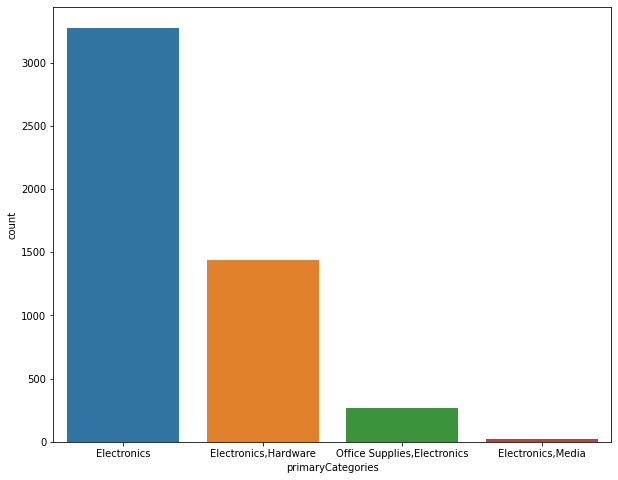

In [ ]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.countplot(x=df.primaryCategories)

**Penjelasan** : pada chart diatas produk yang paling banyak dipilih adalah kategori elektronik.

In [ ]:
df.rename(columns={"reviews.rating":"reviewsRating"},inplace=True)

In [ ]:
rev_rating = df['reviewsRating'].value_counts()
rev_rating

5    3478
4    1208
3     197
1      63
2      54
Name: reviewsRating, dtype: int64

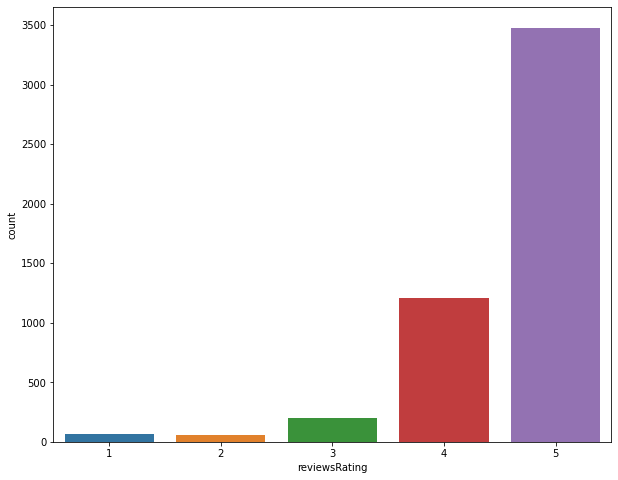

In [ ]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.countplot(x="reviewsRating", data=df)

**penjelasan** : pada chart diatas dapat disimpulkan banyak user yang memberi rating 5.

In [ ]:
df.rename(columns={"reviews.doRecommend":"reviewsRecommend"},inplace=True)

In [ ]:
rev_rec = df['reviewsRecommend'].value_counts()
rev_rec

True     4765
False     235
Name: reviewsRecommend, dtype: int64

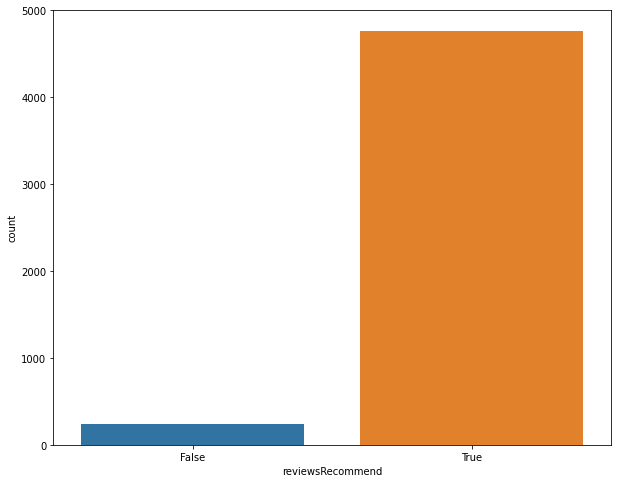

In [ ]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.countplot(x="reviewsRecommend", data=df)

**Penjelasan** : pada chart diatas menggambarkan pada kolom reviewsRecommend, user yang membeli produk merekomendasikan produk yang mereka beli. 

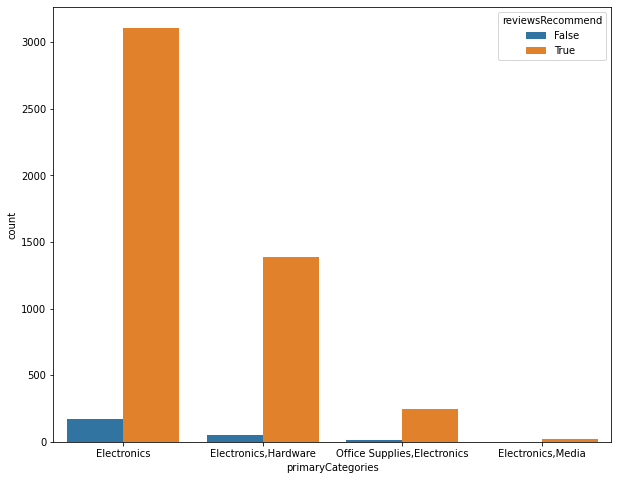

In [ ]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.countplot(x="primaryCategories",hue="reviewsRecommend", data=df)

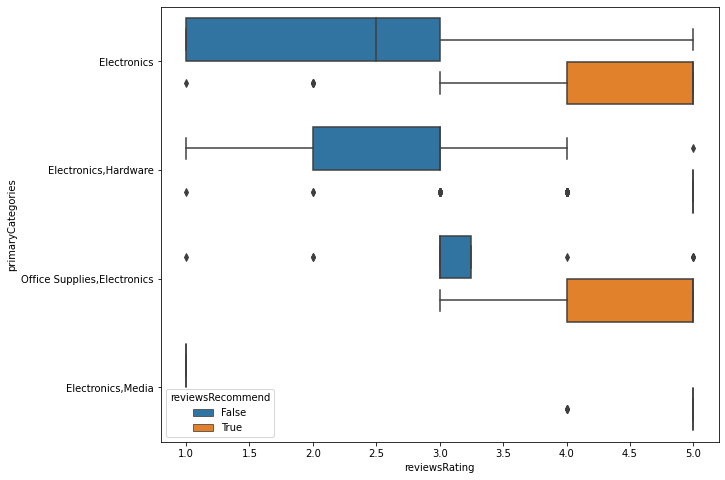

In [ ]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.boxplot(x="reviewsRating", y="primaryCategories", hue="reviewsRecommend", data=df)

**Penjelasan** : pada chart diatas dapat dilihat produk yang direkomendasikan user berdasarkan rating, untuk kategori elektronik dan elektronik,hardware dengan rating 4-5. kemudian, tidak merekomendasikan kategori elektronik dengan rating 1-3 dan elektronik,hardware dengan rating 2-3.

# **Data Preparation**

### Menangani Missing Value
---

In [ ]:
df.isnull().sum()

id                       0
dateAdded                0
dateUpdated              0
name                     0
asins                    0
brand                    0
categories               0
primaryCategories        0
imageURLs                0
keys                     0
manufacturer             0
manufacturerNumber       0
reviews.date             0
reviews.dateAdded     3948
reviews.dateSeen         0
reviewsRecommend         0
reviews.id            4971
reviews.numHelpful       0
reviewsRating            0
reviews.sourceURLs       0
reviews.text             0
reviews.title           13
reviews.username         0
sourceURLs               0
dtype: int64

**Penjelasan** : Setelah melakukan pengecekan missing value dengan perintah `isnull().sum()` terdapat banyak missing value, tetapi pada pembuatan model disini hanya akan menggunakan kolom reviews.username, id dan reviewsRating saja, jadi saya membuat variabel baru untuk menampung kolom-kolom ini.

In [ ]:
df[['reviews.username','id','reviewsRating']]

,reviews.username,id,reviewsRating
0,llyyue,AVqVGZNvQMlgsOJE6eUY,3
1,Charmi,AVqVGZNvQMlgsOJE6eUY,5
2,johnnyjojojo,AVqVGZNvQMlgsOJE6eUY,4
3,Kdperry,AVqVGZNvQMlgsOJE6eUY,5
4,Johnnyblack,AVqVGZNvQMlgsOJE6eUY,5
...,...,...,...
4995,litle,AVqkIdZiv8e3D1O-leaJ,5
4996,gracie,AVqkIdZiv8e3D1O-leaJ,5
4997,Hawk,AVqkIdZiv8e3D1O-leaJ,4
4998,Mrbilly,AVqkIdZiv8e3D1O-leaJ,5


### Train Test Split
---
Pada pembuatan model sistem rekomendasi ini saya membagi 2 data train dant test dengan skala pembagian 80:20.

In [ ]:
reader = Reader()
data = Dataset.load_from_df(df[['reviews.username','id','reviewsRating']], reader)

In [ ]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.20, random_state=50)

# **Modelling**
---
Pada tahap ini saya mengembangkan model dengan menggunakan algoritma `matrix factorization` dengan `Singular Value Decomposition (SVD)`.

In [ ]:
from surprise import SVD
algo_svd = SVD()
prediction_mf = algo_svd.fit(trainset).test(testset)

In [ ]:
prediction_mf

[Prediction(uid='boste03', iid='AVqkIhwDv8e3D1O-lebb', r_ui=5.0, est=4.574463443044539, details={'was_impossible': False}),
 Prediction(uid='Kevinandkalii', iid='AVqkIj9snnc1JgDc3khU', r_ui=5.0, est=4.677739281914075, details={'was_impossible': False}),
 Prediction(uid='PT53226', iid='AWFUWc8THh53nbDRF6YO', r_ui=4.0, est=4.670503315687246, details={'was_impossible': False}),
 Prediction(uid='kimb', iid='AVpgdkC8ilAPnD_xsvyi', r_ui=5.0, est=4.42598106216336, details={'was_impossible': False}),
 Prediction(uid='Colleen', iid='AVph0EeEilAPnD_x9myq', r_ui=5.0, est=4.626385189925256, details={'was_impossible': False}),
 Prediction(uid='Lintor', iid='AWFUWc8THh53nbDRF6YO', r_ui=5.0, est=4.670503315687246, details={'was_impossible': False}),
 Prediction(uid='Jays', iid='AVpgdkC8ilAPnD_xsvyi', r_ui=5.0, est=4.4696832118781495, details={'was_impossible': False}),
 Prediction(uid='Squirl', iid='AWK8z0pOIwln0LfXlSxH', r_ui=5.0, est=4.819859638198577, details={'was_impossible': False}),
 Predictio

# **Model Evaluation**
---
Pada tahap evaluasi model saya mengukur performa akurasi dan nilai error pada model menggunakan metode evaluasi RMSE, MAE dan FCP. 

In [ ]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, reviewsRating in top_n.items():
        reviewsRating.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = reviewsRating[:n]

    return top_n

In [ ]:
testset = trainset.build_anti_testset()
predictions = algo_svd.test(testset)

top_n = get_top_n(predictions, n=10)

In [ ]:
for uid, reviewsRating in top_n.items():
    print(uid, [iid for (iid, _) in reviewsRating])

jedkon1 ['AVpfIfGA1cnluZ0-emyp', 'AWMjT0WguC1rwyj_rFh3', 'AVph0EeEilAPnD_x9myq', 'AVpidLjVilAPnD_xEVpI', 'AVqVGZSEQMlgsOJE6eUc', 'AVphPmHuilAPnD_x3E5h', 'AVqVGWLKnnc1JgDc3jF1', 'AVqVGZO3nnc1JgDc3jGK', 'AWFUWc8THh53nbDRF6YO', 'AVpgdkC8ilAPnD_xsvyi']
JShore ['AVpgdkC8ilAPnD_xsvyi', 'AVpftoij1cnluZ0-p5n2', 'AWMjT0WguC1rwyj_rFh3', 'AVpfIfGA1cnluZ0-emyp', 'AVqVGZN9QMlgsOJE6eUZ', 'AVpjEN4jLJeJML43rpUe', 'AWK8z0pOIwln0LfXlSxH', 'AV-XeQLWuC1rwyj_gbP5', 'AVqkIhwDv8e3D1O-lebb', 'AVqkIiKWnnc1JgDc3khH']
Theresa ['AVqkIh8WQMlgsOJE6fu-', 'AV-XeQLWuC1rwyj_gbP5', 'AVqVGZN9QMlgsOJE6eUZ', 'AVpgdkC8ilAPnD_xsvyi', 'AVpftoij1cnluZ0-p5n2', 'AVphPmHuilAPnD_x3E5h', 'AWFUWc8THh53nbDRF6YO', 'AVpjEN4jLJeJML43rpUe', 'AVpfIfGA1cnluZ0-emyp', 'AVpidLjVilAPnD_xEVpI']
N1BBcustomer ['AVqVGZN9QMlgsOJE6eUZ', 'AV-XeQLWuC1rwyj_gbP5', 'AVpidLjVilAPnD_xEVpI', 'AWMjT0WguC1rwyj_rFh3', 'AWK8z0pOIwln0LfXlSxH', 'AVpfIfGA1cnluZ0-emyp', 'AVpgdkC8ilAPnD_xsvyi', 'AVqkIh8WQMlgsOJE6fu-', 'AWFUWc8THh53nbDRF6YO', 'AVpftoij1cnluZ0-p5n2']


In [ ]:
recom_svd = algo_svd.predict(uid='jedkon1',iid='AVpfIfGA1cnluZ0-emyp')
recom_svd

Prediction(uid='jedkon1', iid='AVpfIfGA1cnluZ0-emyp', r_ui=None, est=4.853274597610201, details={'was_impossible': False})

**Penjelasan** : pada sel kode diatas saya mencoba melakukan tes rekomendasi, dari output yang dihasilkan pengguna dengan user id 'jedkon1' merekomendasikan produk dengan id 'AVpfIfGA1cnluZ0-emyp' dengan rating tinggi.

In [ ]:
from surprise import accuracy

accuracy.mae(prediction_mf)
accuracy.fcp(prediction_mf)
accuracy.rmse(prediction_mf)

MAE:  0.5739
FCP:  0.3966
RMSE: 0.7952


0.7951939612717659

**Penjelasan** : Kesimpulan dari hasil evaluasi model machine learning sistem rekomendasi yang menggunakan metode `collaborative filtering` dan pengembangannya dengan algoritma `matrix factorization` menggunakan `SVD` memberikan saran rekomendasi kepada user secara efektif.